In [1]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing

from split_dataset import SplitDataset
from pathlib import Path
import pandas as pd 
import flammkuchen as fl

from bouter import EmbeddedExperiment

from matplotlib import pyplot as plt

from skimage import io
import numpy as np 
from scipy import signal
import scipy.io 

from scipy.stats import zscore
from scipy.stats import sem

from scipy.interpolate import interp1d

import seaborn as sns
import json

from mpl_toolkits import mplot3d
%matplotlib widget

from skimage import measure

import networkx as nx
import matplotlib.gridspec as gridspec

import os
import numpy.ma as ma

import mypatterns as mpt

import statsmodels.api as sm

In [2]:
# fish id and condition


fish_id = "211012_f1" # 210317_f3  210320_f1 210317_f2 210316_f2  210317_f0

zf = 2
exp_dur = 4820

trial_dur = 20



In [3]:
# Data and Results paths

master_path = Path(r"\\FUNES\Shared\experiments\E0020_random_coherences\v35_two_options_forward_ol\h2b")
data_path = master_path / fish_id

                           

In [4]:
# Getting time-courses and ROI locations

traces= fl.load(data_path / "data_from_suite2p_cells.h5", "/traces")


In [5]:
# Get experiment for behavioral analysis later


current_exp = EmbeddedExperiment(list(data_path.glob("*metadata.json"))[0])

# This is mainly to get scanning frequency and lag condition

with open(next(data_path.glob("*metadata.json")), "r") as f:
    metadata = json.load(f)
    


In [6]:
stim_log_df = fl.load(next(data_path.glob("*stimulus_log.hdf5")), "/data")

In [7]:
#stim_reg = 1 - stim_log_df.random_dots_frozen

#Choose negative or positive coherence

stim_reg =  1*np.array(stim_log_df.random_dots_coherence > 0)

gr_starts =np.round(stim_log_df.t[np.squeeze(np.argwhere(np.diff(stim_reg)==1))]).to_numpy()
gr_ends = np.round(stim_log_df.t[np.squeeze(np.argwhere(np.diff(stim_reg)==-1))]).to_numpy()

In [8]:
reg_dur = trial_dur*zf


reg = np.zeros(int(exp_dur*zf))


reg_starts = (zf*gr_starts).astype(int)
reg_ends = (zf*gr_ends).astype(int)

reg_notr = len(reg_ends)


for t in range(reg_notr):
    reg[reg_starts[t]:reg_ends[t]:1] = 1

In [9]:
# get time-course traces and Preprocessing

TC = traces
nantest = np.sum(TC,axis = -1)
TC = np.squeeze(TC[np.argwhere(~np.isnan(nantest)),:])

fc_baseline=1/300  # Hz, 5 min period
TC=mpt.clean(TC, sampling_frq = zf, highpass = fc_baseline)

X, selected_frames = mpt.select_frames(TC, method = 'REG', time_mask=reg)


In [10]:
# Clustering: States retrieval

centers, cluster_labels, nb_clusters = mpt.get_patterns(X,nb_clusters=5)

In [11]:
coords= fl.load(data_path / "data_from_suite2p_cells.h5", "/coords")


In [12]:
# Coordinates

XYZ = coords
XYZ = np.squeeze(XYZ[np.argwhere(~np.isnan(nantest)),:])

xx =  np.squeeze(XYZ[:,0])
yy =  np.squeeze(XYZ[:,1])
zz = np.squeeze(XYZ[:,2])



In [13]:
# Computing Cluster x trial features


n_clusters = nb_clusters
cluster_labels_trial = cluster_labels.reshape((int(reg_notr), int(reg_dur)))
reg_kk = np.zeros([n_clusters,np.size(X,axis=0)])
reg_kk_trial =  np.zeros([n_clusters, int(reg_notr), int(reg_dur)])
reg_kk_blocks =  np.zeros([n_clusters, int(reg_notr), int(reg_dur)])
reg_kk_blocks_end_pos  =  np.zeros([n_clusters, int(reg_notr), int(reg_dur)])
reg_kk_blocks_duration  =  np.empty([n_clusters, int(reg_notr), int(reg_dur)])
reg_kk_blocks_duration[:] =  np.NaN
reg_kk_blocks_positions  =  np.empty([n_clusters, int(reg_notr), int(reg_dur)])
reg_kk_blocks_positions[:]  =  np.NaN


meanposition_occ_per_trial = np.empty([n_clusters, int(reg_notr)])
meanposition_occ_per_trial[:] = np.NaN

occ_trial_first = np.empty([n_clusters, int(reg_notr)])
occ_trial_first[:] = np.NaN


for k in range(n_clusters):
    reg_kk[k,:] = (cluster_labels == k)  
    reg_kk_trial[k,:,:] = (cluster_labels_trial == k)
    
    
occ_per_trial = np.sum(reg_kk_trial,2)    


for k in range(n_clusters):
    for ntr in range(reg_notr):
        cur_tri = np.argwhere(reg_kk_trial[k,ntr,:])
        if (occ_per_trial[k,ntr] > 0):
            occ_trial_first[k,ntr] = cur_tri[0]
            meanposition_occ_per_trial[k,ntr] = np.mean(cur_tri)
            all_labels = measure.label(reg_kk_trial[k,ntr,:],background=0)
            for some_label in range(1, max(all_labels)+1):
                inds_label =  np.argwhere(all_labels == some_label)
                reg_kk_blocks[k,ntr,inds_label[0].astype(int)] = 1
                reg_kk_blocks_positions[k,ntr,inds_label[0].astype(int)] = inds_label[0]
                reg_kk_blocks_duration[k,ntr,inds_label[0].astype(int)] =  inds_label[-1]  - inds_label[0]
                if inds_label[-1] + 1 < reg_dur:
                    reg_kk_blocks_end_pos[k,ntr, inds_label[-1] + 1] =1


                
reg_kk_trial_blocks = np.sum(reg_kk_blocks, -1)
reg_kk_trial_blocks_duration = np.nanmean(reg_kk_blocks_duration, -1)
reg_kk_trial_blocks_positions = np.nanmean(reg_kk_blocks_positions, -1)



C:\Users\Younes\anaconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\Younes\anaconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: Mean of empty slice


In [14]:
# Reordering states in order of average occurence timimg after trial on-set

up_inds = np.argsort(np.nanmean(reg_kk_trial_blocks_positions, -1))

occ_per_trial= occ_per_trial[up_inds,:]
occ_trial_first = occ_trial_first[up_inds,:]/zf
reg_kk_trial_blocks = reg_kk_trial_blocks[up_inds,:]
reg_kk_trial_blocks_duration = reg_kk_trial_blocks_duration[up_inds,:]/zf
reg_kk_trial_blocks_positions = reg_kk_trial_blocks_positions[up_inds,:]/zf



centers = centers[up_inds,:]



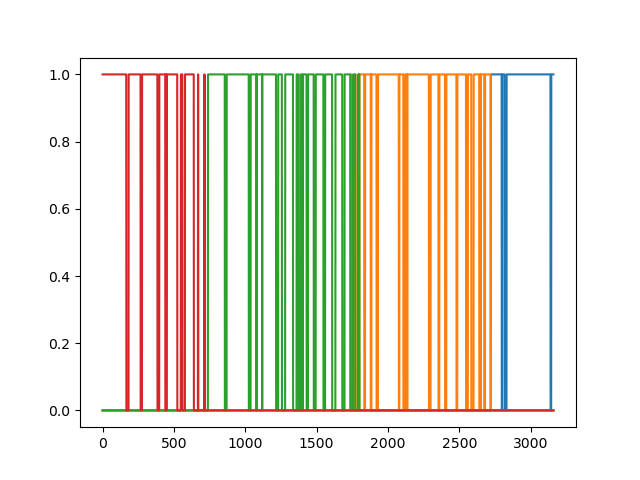

In [16]:
plt.close('all') 
plt.clf 

plt.plot(cluster_labels==0)
plt.plot(cluster_labels==1)
plt.plot(cluster_labels==2)
plt.plot(cluster_labels==4)


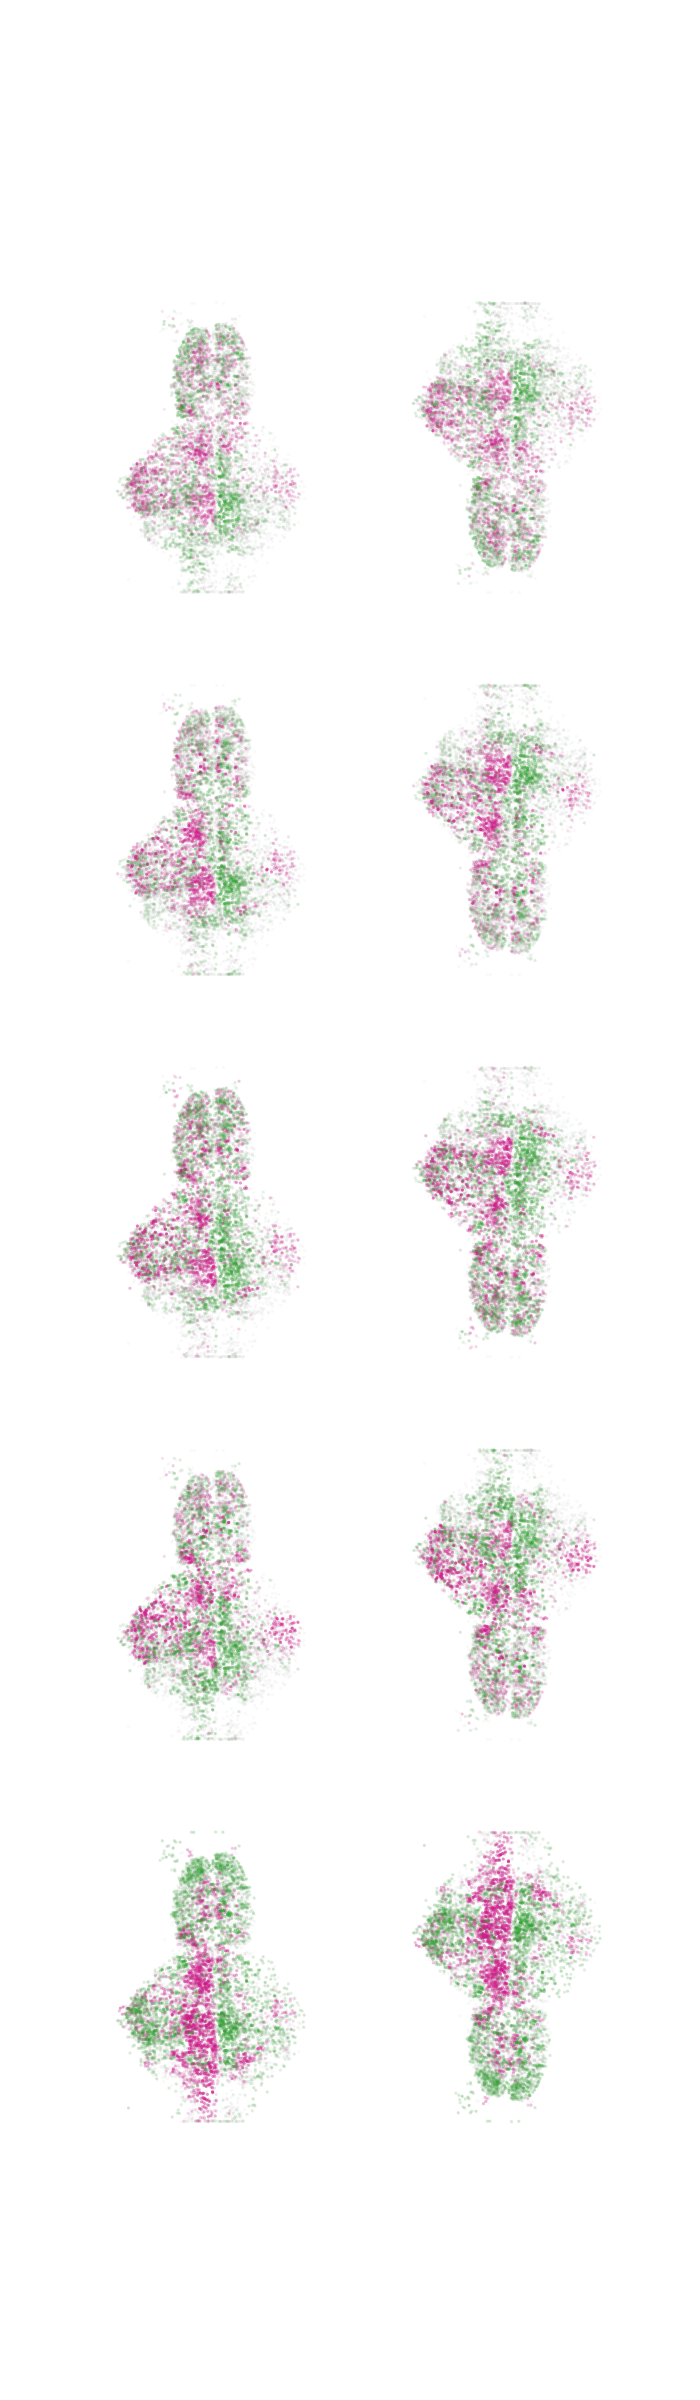

In [17]:
# ploting states

plt.close('all') 
plt.clf 

f, axs = plt.subplots(n_clusters, 2, figsize=(7, 24))


for i in range(n_clusters):


    X0=centers[i,:]
    Xplot = np.squeeze(X0)
    Xplot -= np.mean(Xplot)
    Xplot /= np.std(Xplot)
    Xplot[np.abs(Xplot) < .5] = 0


    mxp = np.ceil(max(np.abs(Xplot)))+1



    axs[i,0].scatter(
        yy, zz, lw=0, s=5, alpha=0.03, color=(0.3,) * 3,
    )
    axs[i,0].scatter(
        yy, zz, lw=0, s=5, alpha=np.multiply(abs(Xplot/mxp),(Xplot>0)), color='#d01c8b',
    )
    axs[i,0].scatter(
        yy, zz, lw=0, s=5, alpha=np.multiply(abs(Xplot/mxp),(Xplot<0)), color='#2ca02c',
    )
    axs[i,0].axis("equal")
    axs[i,0].axis("off")
    #axs[i,0].set_title("Occurres in {:1.4} % of trials on average around  {:1.3} sec. ".format(np.count_nonzero(reg_kk_trial_blocks[i,:])*100 / np.size(reg_kk_trial_blocks, axis =1), np.nanmean(reg_kk_trial_blocks_positions[i,:])))



    axs[i,1].scatter(
        yy, -zz, lw=0, s=5, alpha=0.03, color=(0.3,) * 3,
    )

    axs[i,1].scatter(
        yy, -zz, lw=0, s=5, alpha=np.multiply(abs(Xplot/mxp),(Xplot>0)), color='#d01c8b',
    )
    axs[i,1].scatter(
        yy, -zz, lw=0, s=5, alpha=np.multiply(abs(Xplot/mxp),(Xplot<0)), color='#2ca02c',
    )
    axs[i,1].axis("equal")
    axs[i,1].axis("off")
    
#f.suptitle("Clusters during {} / Stimuli lag = {}".format(condition,protocol_params["lag"]))    
#plt.savefig('{}/Clusters_anat.png'.format(results_path), format='png')
#plt.savefig('{}/Clusters_anat.pdf'.format(results_path), format='pdf')
    
    
plt.show()    

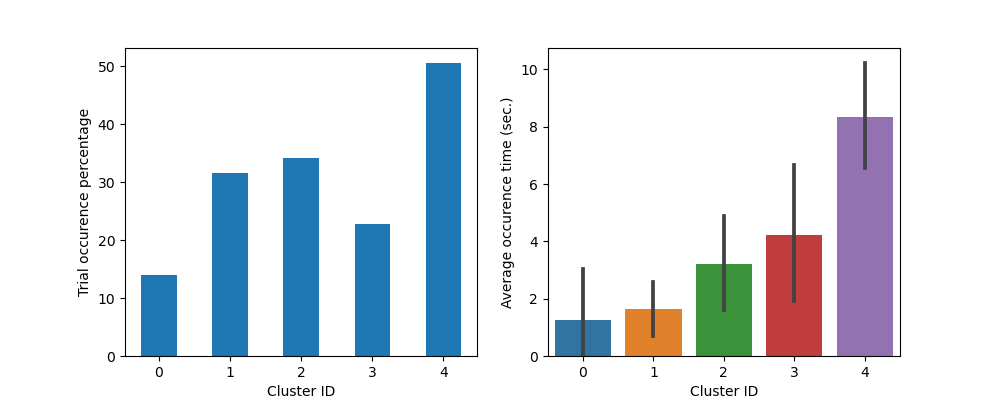

In [18]:
# cluster analysis (trial percentage and mean occurence time):


Cluster_trial_percentage = np.zeros(n_clusters)
width = .5  

plt.close('all') 
plt.clf 


for nc in range(n_clusters):
      Cluster_trial_percentage[nc] = np.count_nonzero(reg_kk_trial_blocks[nc,:])*100 / np.size(reg_kk_trial_blocks, axis =1)


f, axs = plt.subplots(1, 2, figsize=(10, 4))


axs[0].bar(np.arange(0, n_clusters),np.transpose(Cluster_trial_percentage), width)
axs[0].set_xlabel('Cluster ID')
axs[0].set_ylabel('Trial occurence percentage')

sns.barplot(data=np.transpose(reg_kk_trial_blocks_positions))
axs[1].set_xlabel('Cluster ID')
axs[1].set_ylabel('Average occurence time (sec.)')

plt.show()




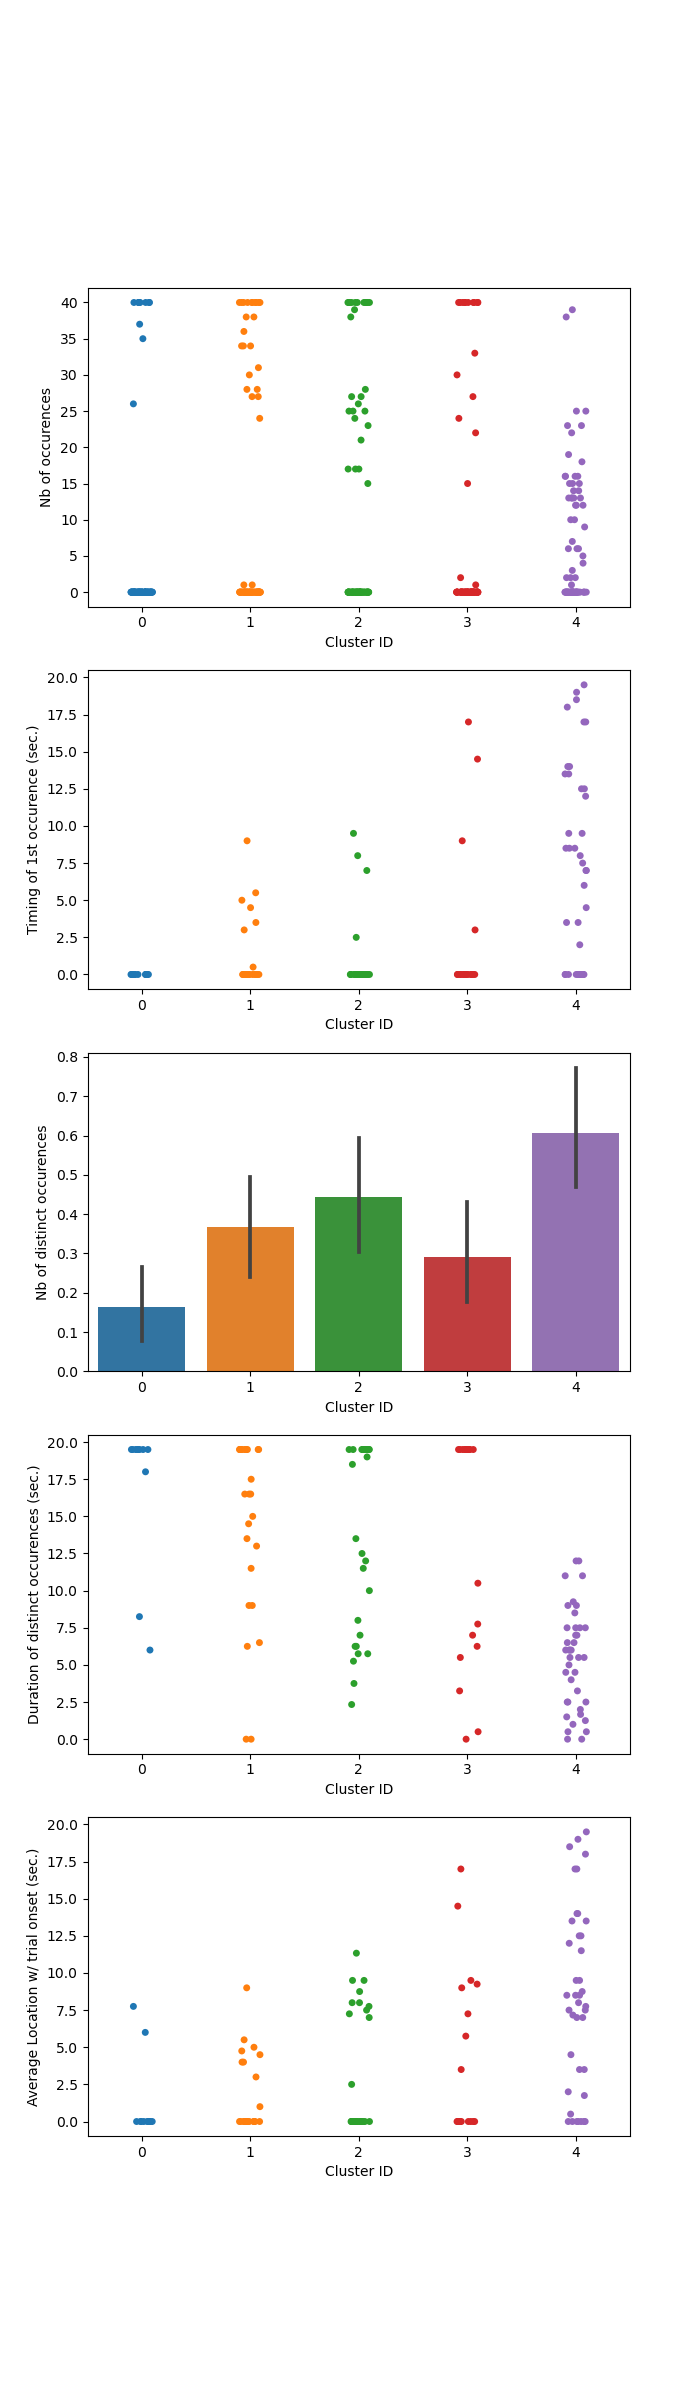

In [19]:
# cluster feature analysis:
# There are 5 measures: 
# occ_per_trial occ_trial_first reg_kk_trial_blocks  reg_kk_trial_blocks_duration reg_kk_trial_blocks_positions

num_feat = 5

plt.close('all') 
plt.clf 

f, axs = plt.subplots(num_feat, 1, figsize=(7, 24))


sns.stripplot(ax=axs[0],data=np.transpose(occ_per_trial))
#axs[0].set_title('occ per trial')
axs[0].set_xlabel('Cluster ID')
axs[0].set_ylabel('Nb of occurences')



sns.stripplot(ax=axs[1],data=np.transpose(occ_trial_first))
#axs[1].set_title('first trial occ')
axs[1].set_xlabel('Cluster ID')
axs[1].set_ylabel('Timing of 1st occurence (sec.)')




sns.barplot(ax=axs[2],data=np.transpose(reg_kk_trial_blocks))
#axs[2].set_title('distinct occ per trial')
axs[2].set_xlabel('Cluster ID')
axs[2].set_ylabel('Nb of distinct occurences')



sns.stripplot(ax=axs[3],data=np.transpose(reg_kk_trial_blocks_duration))
#axs[3].set_title('State Duration Average')
axs[3].set_xlabel('Cluster ID')
axs[3].set_ylabel('Duration of distinct occurences (sec.)')



sns.stripplot(ax=axs[4],data=np.transpose(reg_kk_trial_blocks_positions))
#axs[4].set_title('Average Location w/ trial onset')
axs[4].set_xlabel('Cluster ID')
axs[4].set_ylabel('Average Location w/ trial onset (sec.)')




plt.show()




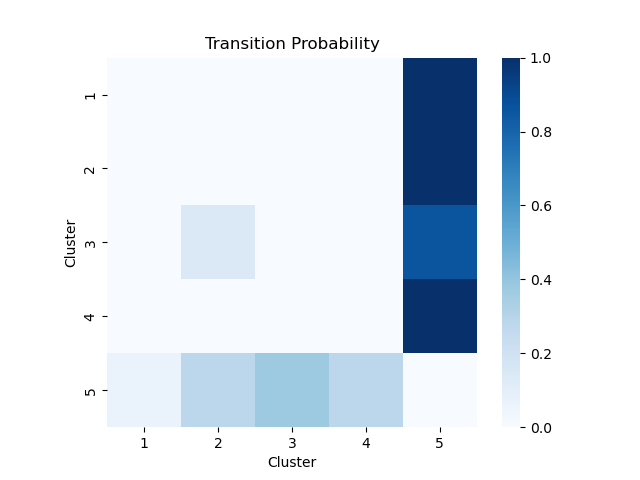

In [20]:
# Sequential Analysis (State Coupling) Example


COUPLINGS = np.zeros([n_clusters,n_clusters])

for i in range(n_clusters):
    k1 = up_inds[i]
    cp = cluster_labels[np.argwhere(np.reshape(reg_kk_blocks_end_pos[k1,:],int(reg_notr*reg_dur)) == 1) ]
    for j in range(n_clusters):
        k2 = up_inds[j]
        COUPLINGS[i,j] = np.sum(cp == k2)/len(cp)
        
        
plt.close('all') 
plt.clf 

my_cmap2 = plt.get_cmap('Blues')

ax = sns.heatmap(
    COUPLINGS, 
    cmap=my_cmap2,
    square=True
)

ax.set_xticklabels(np.arange(1, n_clusters+1))
ax.set_yticklabels(np.arange(1, n_clusters+1))

plt.xlabel("Cluster") 
plt.ylabel("Cluster") 
plt.title('Transition Probability')    
plt.show()


C:\Users\Younes\anaconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


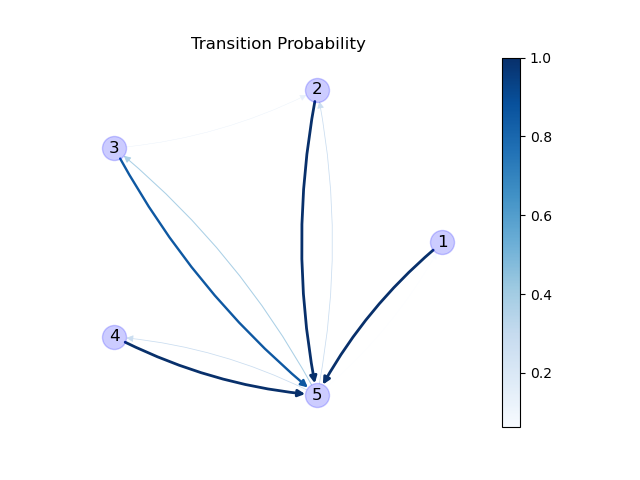

In [21]:
# Sequential Analysis (State Coupling) Transitions Diagram


G = nx.DiGraph(COUPLINGS)
pos = nx.circular_layout(G)
#pos = nx.random_layout(G)

Glabels = {}    
for node in G.nodes():
        #set the node name as the key and the label as its value 
        Glabels[node] = str(node+1)
        
edges = nx.draw_networkx_edges(
    G, pos, edge_cmap=my_cmap2, connectionstyle="arc3,rad=0.1" ,
    edge_color=[G[u][v]['weight'] for u, v in G.edges], width = [G[u][v]['weight'] for u, v in G.edges],arrows=False)

plt.close('all') 
plt.clf 

mcl = nx.draw_networkx_edges(
    G, pos, edge_cmap=my_cmap2, connectionstyle="arc3,rad=0.1" ,
    edge_color=[G[u][v]['weight'] for u, v in G.edges], width = [2*G[u][v]['weight'] for u, v in G.edges])

nx.draw_networkx_nodes(G, pos,node_color = 'b', node_size = 300, alpha = .2, )
nx.draw_networkx_labels(G, pos, Glabels)

plt.colorbar(edges)
plt.axis('off')
plt.title('Transition Probability') 

plt.show()

                